### Introduction
In this kernel we will use various predictive models to see how accurate they are in detecting whether a transaction is a normal payment or a fraud. As described in the dataset, the features are scaled and the names of the features are not shown due to privacy reasons. Nevertheless, we can still analyze some important aspects of the dataset. Let's start!

### Outline:
#### Exploratory Data Analysis
1) Reading and Understanding Data  
2) Visualize Transaction Count by Hour  
3) Visualize Transaction Amount by Hour
4) Finding Feature Correlation

#### Data Preprocessing
1) Feature Scaling  
2) Train-Test Split  

#### Testing Classifiers for Fraud Detection
1) Testing on original dataset with imbalanced classes  
2) Testing on sampled dataset with balanced classes  
3) Testing on original dataset with balanced classes  
4) Conclusion

In [1]:
import numpy as np

import pandas as pd
pd.set_option('max_rows', 50)   
pd.set_option('max_columns', 100)
pd.set_option('precision', 2)   # round to two decimal points
pd.set_option('float_format', '{:,.2f}'.format)   # suppress scientific notation globally

import time

import matplotlib.pyplot as plt
plt.style.use('seaborn')
%matplotlib inline

import seaborn as sns
sns.set_theme(style='darkgrid', context='notebook', palette='muted', font='sans-serif', font_scale=1, color_codes=True)

import warnings
warnings.filterwarnings('ignore')

## Exploratory Data Analysis

### Reading and Understanding Data

In [2]:
creditcard = pd.read_csv('creditcard.csv')
creditcard.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.00,-1.36,-0.07,2.54,1.38,-0.34,0.46,0.24,0.10,0.36,0.09,-0.55,-0.62,-0.99,-0.31,1.47,-0.47,0.21,0.03,0.40,0.25,-0.02,0.28,-0.11,0.07,0.13,-0.19,0.13,-0.02,149.62,0
1,0.00,1.19,0.27,0.17,0.45,0.06,-0.08,-0.08,0.09,-0.26,-0.17,1.61,1.07,0.49,-0.14,0.64,0.46,-0.11,-0.18,-0.15,-0.07,-0.23,-0.64,0.10,-0.34,0.17,0.13,-0.01,0.01,2.69,0
2,1.00,-1.36,-1.34,1.77,0.38,-0.50,1.80,0.79,0.25,-1.51,0.21,0.62,0.07,0.72,-0.17,2.35,-2.89,1.11,-0.12,-2.26,0.52,0.25,0.77,0.91,-0.69,-0.33,-0.14,-0.06,-0.06,378.66,0
3,1.00,-0.97,-0.19,1.79,-0.86,-0.01,1.25,0.24,0.38,-1.39,-0.05,-0.23,0.18,0.51,-0.29,-0.63,-1.06,-0.68,1.97,-1.23,-0.21,-0.11,0.01,-0.19,-1.18,0.65,-0.22,0.06,0.06,123.50,0
4,2.00,-1.16,0.88,1.55,0.40,-0.41,0.10,0.59,-0.27,0.82,0.75,-0.82,0.54,1.35,-1.12,0.18,-0.45,-0.24,-0.04,0.80,0.41,-0.01,0.80,-0.14,0.14,-0.21,0.50,0.22,0.22,69.99,0


In [3]:
creditcard.shape

(284807, 31)

In [4]:
creditcard.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [5]:
creditcard['Class'].value_counts(normalize=True)*100

0   99.83
1    0.17
Name: Class, dtype: float64

*Summary of Data*  
- There are no null values in data set  


- Class 0 is Legit transactions. Class 1 is Fraud transactions  


- We have huge imbalance in our dataset with less than 1% fraud transactions.  
  Note: If we use this dataframe as is for our prediction , our algorithm will probably overfit since it will assume that most   transactions are not fraud, and we might get a lot of errorsLater.So, we will deal with this imbalance later on.  


- Data provided is already transformed using PCA. In order to use PCA, data needs to be scaled before, so we assume that all features except Amount and Time have already been scaled as well. 

### Visualize Transaction Count by Hour
Column 'Time' is the seconds elapsed from the first transaction in the dataset. For data exploration and visualization, let's convert this to 'hours' of a day.

In [6]:
creditcard['hour'] = creditcard['Time'].apply(lambda x: np.ceil(float(x)/3600) % 24)
creditcard.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class,hour
0,0.00,-1.36,-0.07,2.54,1.38,-0.34,0.46,0.24,0.10,0.36,0.09,-0.55,-0.62,-0.99,-0.31,1.47,-0.47,0.21,0.03,0.40,0.25,-0.02,0.28,-0.11,0.07,0.13,-0.19,0.13,-0.02,149.62,0,0.00
1,0.00,1.19,0.27,0.17,0.45,0.06,-0.08,-0.08,0.09,-0.26,-0.17,1.61,1.07,0.49,-0.14,0.64,0.46,-0.11,-0.18,-0.15,-0.07,-0.23,-0.64,0.10,-0.34,0.17,0.13,-0.01,0.01,2.69,0,0.00
2,1.00,-1.36,-1.34,1.77,0.38,-0.50,1.80,0.79,0.25,-1.51,0.21,0.62,0.07,0.72,-0.17,2.35,-2.89,1.11,-0.12,-2.26,0.52,0.25,0.77,0.91,-0.69,-0.33,-0.14,-0.06,-0.06,378.66,0,1.00
3,1.00,-0.97,-0.19,1.79,-0.86,-0.01,1.25,0.24,0.38,-1.39,-0.05,-0.23,0.18,0.51,-0.29,-0.63,-1.06,-0.68,1.97,-1.23,-0.21,-0.11,0.01,-0.19,-1.18,0.65,-0.22,0.06,0.06,123.50,0,1.00
4,2.00,-1.16,0.88,1.55,0.40,-0.41,0.10,0.59,-0.27,0.82,0.75,-0.82,0.54,1.35,-1.12,0.18,-0.45,-0.24,-0.04,0.80,0.41,-0.01,0.80,-0.14,0.14,-0.21,0.50,0.22,0.22,69.99,0,1.00


In [7]:
count_pivot = creditcard.pivot_table(index='hour', columns = 'Class', values = 'Amount', aggfunc = 'count')
count_pivot

Class,0,1
hour,,
0.00,10919,21
1.00,7687,6
2.00,4212,10
3.00,3269,57
4.00,3476,17
5.00,2185,23
6.00,2979,11
7.00,4093,9
8.00,7219,23


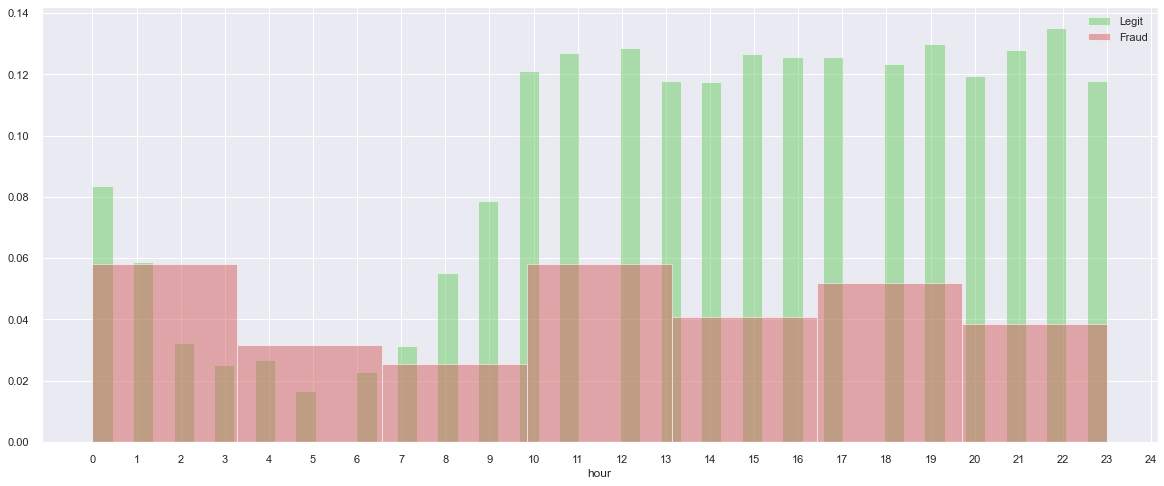

In [8]:
plt.figure(figsize=(20,8))

sns.distplot(creditcard['hour'][creditcard['Class'] == 0], kde=False, norm_hist=True, color='g', hist_kws={'alpha':.5}, label='Legit')
sns.distplot(creditcard['hour'][creditcard['Class'] == 1], kde=False, norm_hist=True, color='r', hist_kws={'alpha':.5}, label='Fraud')
plt.xticks(range(0,25))
plt.legend()
plt.show();

*Observations*
- Very few overall transactions overnight (1AM - 7AM). Starts increasing after that and remains consistent throughout the day. 
- Fraud transactions at its peak between (12AM - 3AM), and also during morning hours(10AM - 1PM) and evening hours(5PM - 8PM)

### Visualize Transaction Amount by Hour

In [9]:
amnt_pivot = creditcard.groupby(['hour','Class'])['Amount'].mean().to_frame().reset_index()
amnt_pivot.head()

,hour,Class,Amount
0,0.00,0,68.76
1,0.00,1,149.67
2,1.00,0,60.14
3,1.00,1,303.34
4,2.00,0,62.48


<AxesSubplot:xlabel='hour', ylabel='Amount'>

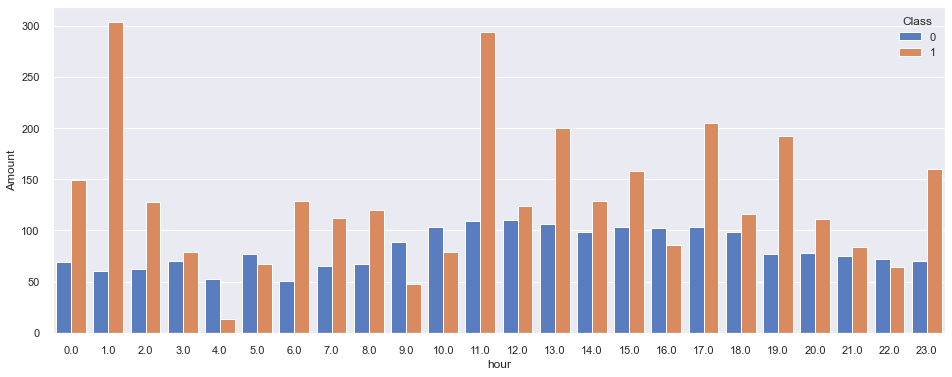

In [10]:
plt.figure(figsize=(16,6))
sns.barplot(data=amnt_pivot, x='hour', y='Amount', hue='Class')

*Observations*  
- Fraud transaction amount is highest during hours - 1 AM and 11 AM
- At 1 AM, even though transaction count is among lowest, it seems most of that amount transacted is fraud.
- At 11 AM, transaction count itself has increased, but still fraud amount is disproportionatily high.

### Feature Correlation

<AxesSubplot:>

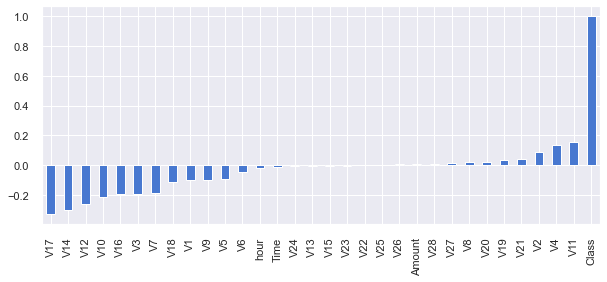

In [11]:
creditcard.corr()['Class'].sort_values().plot.bar(figsize=(10,4))

Due to a highly imbalanced dataset, we may not able to see the true correlations between the class and features.  

Let's quickly create a small sampled and balanced dataframe below after feature scaling and check correlation again.

In [36]:
creditcard['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [38]:
card_sample = creditcard.sample(frac=1)

fraud_df = df.loc[df['Class'] == 1]
non_fraud_df = df.loc[df['Class'] == 0][:492]

card_sample = pd.concat([fraud_df, non_fraud_df])

card_sample = df_sample.sample(frac=1, random_state=42)

card_sample.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class,hour
150661,0.11,-6.19,7.10,-13.03,8.01,-7.89,-3.97,-12.23,4.97,-4.25,-12.97,8.69,-17.18,0.07,-14.12,0.96,-12.38,-18.72,-6.52,3.52,0.48,2.50,0.48,0.48,0.36,-0.29,-0.20,-0.20,0.40,0.32,1,3.00
73857,-0.35,-6.16,1.47,-6.85,5.17,-2.99,-1.80,-6.55,2.62,-3.61,-8.12,6.03,-9.23,-1.55,-10.31,0.31,-7.79,-12.82,-4.37,2.64,-0.29,1.06,0.13,0.59,-0.57,0.58,-0.04,0.95,0.16,-0.30,1,16.00
161096,0.34,-1.38,1.18,-1.69,-0.47,0.34,-0.61,-0.19,1.04,-0.72,-0.76,-0.52,0.98,0.67,1.42,-0.28,0.41,-0.62,1.05,0.74,-0.47,0.56,1.25,-0.17,-0.97,-0.70,-0.22,-0.31,-0.08,-0.29,0,8.00
234574,0.74,-1.05,4.36,-6.02,5.30,1.48,-2.19,-1.53,0.63,-4.04,-6.29,3.54,-7.96,-1.67,-12.46,-0.21,-1.42,-3.24,0.06,-1.80,0.53,0.40,-0.95,-0.38,-0.22,0.26,0.05,0.85,0.53,-0.31,1,18.00
154676,0.21,-1.46,3.74,-7.40,7.44,-1.55,-1.66,-5.76,1.62,-2.19,-6.81,6.83,-10.40,1.84,-11.87,-3.64,-6.04,-9.75,-3.12,0.07,0.53,0.96,0.15,-0.04,-0.54,-0.76,-0.01,0.32,-0.32,-0.28,1,5.00


In [39]:
card_sample['Class'].value_counts()

1    492
0    492
Name: Class, dtype: int64

<AxesSubplot:>

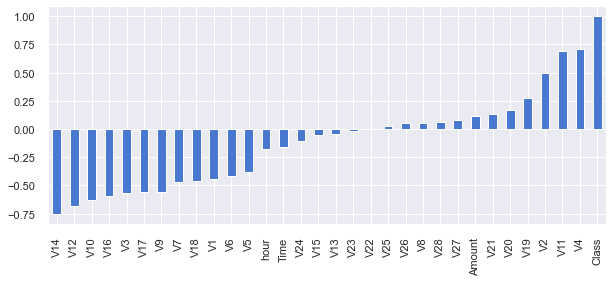

In [40]:
card_sample.corr()['Class'].sort_values().plot.bar(figsize=(10,4))

*Observations*  
- Now we clearly see the correlations
- V14, V12, V10, V16, V3, V17 and V9 are negatively correlated, with correlation above 50%
- V2, V11 and V4 are positively correlated, with correlation above 50%

## Data Preprocessing

### Feature Scaling
We will now scale Time and Amount columns. Ideally, scaling methods must be fit only on training set and then both training and test sets should be transformed. This is to avoid data leakage. But our complete dataset was already scaled and transformed using PCA, so to have these 2 columns scaled in similar fashion, we will scale them before split only.

In [19]:
from sklearn.preprocessing import RobustScaler  # Robust Scaler is less prone to outliers

In [23]:
# Create a copy of original data as backup
creditcard_copy = creditcard.copy()

# Change original data
creditcard['Amount'] = RobustScaler().fit_transform(creditcard['Amount'].values.reshape(-1,1))
creditcard['Time'] = RobustScaler().fit_transform(creditcard['Time'].values.reshape(-1,1))

### Train-Test Split

In [25]:
from sklearn.model_selection import train_test_split

In [102]:
X = creditcard.drop('Class', axis=1)
y = creditcard['Class']

In [103]:
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=3)

In [108]:
y_train.value_counts()

0    213236
1       369
Name: Class, dtype: int64

In [109]:
y_test.value_counts()

0    71079
1      123
Name: Class, dtype: int64

In [41]:
X_sampled = card_sample.drop('Class', axis=1)
y_sampled = card_sample['Class']

In [43]:
X_train_sampled, X_test_sampled, y_train_sampled, y_test_sampled = train_test_split(X_sampled, y_sampled, test_size=0.25, stratify=y_sampled, random_state=3)

In [44]:
y_train_sampled.value_counts()

1    369
0    369
Name: Class, dtype: int64

In [45]:
y_test_sampled.value_counts()

1    123
0    123
Name: Class, dtype: int64

## Testing Classifiers for Fraud Detection

First, we will use base version of Logistic Regression to test 
- Original dataset with imbalanced classes
- Sampled dataset with balanced classes
- Original dataset with balanced classes

### Testing on original dataset with imbalanced classes

In [48]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_validate

from sklearn.metrics import\
classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, precision_recall_curve,\
make_scorer, precision_score, recall_score, f1_score

In [49]:
# Define dictionary with performance metrics
scoring = {'precision':make_scorer(precision_score),
           'recall':make_scorer(recall_score), 
           'f1_score':make_scorer(f1_score)}

In [ ]:
log_model = LogisticRegression()
folds = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

log_scores = cross_validate(log_model, X_train, y_train, cv=folds, scoring=scoring)

print('precision: ', log_scores['test_precision'].mean())
print('recall: ', log_scores['test_recall'].mean())
print('f1 score: ', log_scores['test_f1_score'].mean())

precision:  0.8617458087442602
recall:  0.5881031716648155
f1 score:  0.6983417552807141


Precision is good, but recall score is poor dragging down f1 score as well

### Testing on sampled dataset with balanced classes

In [55]:
log_sample_scores = cross_validate(log_model, X_train_sampled, y_train_sampled, cv=folds, scoring=scoring)

print('precision: ', log_sample_scores['test_precision'].mean())
print('recall: ', log_sample_scores['test_recall'].mean())
print('f1 score: ', log_sample_scores['test_f1_score'].mean())

precision:  0.969943730787989
recall:  0.9160187584845119
f1 score:  0.9418648487544031


All scores are excellent, but this score is on data sample which is less than 1% of our original data.  
But we understand that balancing classses is important, and so next we will perform balancing on original data.

### Testing on original dataset with balanced classes

***Handling imbalance using Class-Weights***

In [46]:
# Checking class weights to be assigned

from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
print(np.unique(y_train),class_weights)

[0 1] [  0.50086524 289.43766938]


In [79]:
# Prediction using above class weights

logr = LogisticRegression(class_weight={0:0.5,1:290})

logr.fit(X_train, y_train)
y_pred = logr.predict(X_test)
    
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99     71079
           1       0.06      0.93      0.11       123

    accuracy                           0.97     71202
   macro avg       0.53      0.95      0.55     71202
weighted avg       1.00      0.97      0.99     71202



*Observations*  
- Recall of Fraud Detection is above 90% now, means model has correctly predicted actual Fraud cases as Fraud.
- But Precision of Fraud Detection is extremely poor, means that model actual ended up predicting a lot of Frauds and most of these did not turn out be actual fraud.  
- We cannot always rely of these calculated weights, as these weights would only result in best possible overall accuracy.  
- There is always a trade-off between precision and recall, which we will need to check manually.  

So now, let's try different class weights and see which ones are able to give us a good score on both precision and recall.

In [110]:
for w in [10,20,50,100,150,200,250,300]:
    print('Weight {} for Fraud Class'.format(w))
    
    logr = LogisticRegression(class_weight={0:1,1:w})
    logr.fit(X_train, y_train)
    y_pred = logr.predict(X_test)
    
    print(classification_report(y_test, y_pred))

Weight 10 for Fraud Class
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.77      0.84      0.80       123

    accuracy                           1.00     71202
   macro avg       0.89      0.92      0.90     71202
weighted avg       1.00      1.00      1.00     71202

Weight 20 for Fraud Class
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.66      0.85      0.74       123

    accuracy                           1.00     71202
   macro avg       0.83      0.93      0.87     71202
weighted avg       1.00      1.00      1.00     71202

Weight 50 for Fraud Class
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.47      0.89      0.61       123

    accuracy                           1.00     71202
   macro avg       0.73      0.94      0.81     71

*Observations*
- As there is huge support(no of records for class 0), weighted F1 score always end up being near perfect 1, but real story lies in precision and recall scores of borh class 0 and 1.  
- Best trade-off for precision and recall is seen weight 10 assigned to Fraud Class.  
- As the weights increase, recall score also increase but precision keeps going down.

#### Testing other Classifiers

Now, that we have found ideal weights for our calsses, let's test few other classifiers as well

In [120]:
from sklearn.svm import LinearSVC
    
lsvc = LinearSVC(class_weight={0:1,1:10})
lsvc.fit(X_train, y_train)
y_pred = lsvc.predict(X_test)
  
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.90      0.80      0.84       123

    accuracy                           1.00     71202
   macro avg       0.95      0.90      0.92     71202
weighted avg       1.00      1.00      1.00     71202



In [145]:
from sklearn.ensemble import RandomForestClassifier
    
rfc = RandomForestClassifier(class_weight={0:1,1:10})
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
  
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.96      0.80      0.88       123

    accuracy                           1.00     71202
   macro avg       0.98      0.90      0.94     71202
weighted avg       1.00      1.00      1.00     71202



RandomForestClassifier performed much better. It has an excellent precision score, but leaves some scope for improvement in recall score.  
In our case of Fraud detection, it is important to have a good recall score means model is able to truly detect fraud transactions as much as possible

***Handling imbalance using oversampling***  

Let's try one of the oversampling methods- SMOTE, and then use RandomForestClassifier again to check performance

In [211]:
# Oversampling minority class, to make it 33% of majority class

from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy=0.33, random_state=3)

X_sample, y_sample = smote.fit_resample(X_train, y_train)

In [207]:
y_sample.value_counts(normalize=True)*100

0   75.19
1   24.81
Name: Class, dtype: float64

In [208]:
y_sample.value_counts()

0    213236
1     70367
Name: Class, dtype: int64

In [209]:
# Run estimation on oversampled data

from sklearn.ensemble import RandomForestClassifier
    
rfc = RandomForestClassifier()
rfc.fit(X_sample, y_sample)
y_pred = rfc.predict(X_test)
  
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.90      0.86      0.88       123

    accuracy                           1.00     71202
   macro avg       0.95      0.93      0.94     71202
weighted avg       1.00      1.00      1.00     71202



We now see that Precision score reduced by 6% and recall increased by same 6%, as compared to model with class weights.   
This is a better trade-off between precision and recall scores

### Conclusion 

Generally, the cost of missing a fraud will outweigh the cost of cancelling some legit customer transactions, so ideally we should have a high recall rate. 

Our model can detect frauds very well (catching 86% of fraud transactions), while at the same time minimizing the user friction and credit card disruptions with a precision of 90%.